# 나의 출퇴근 시간에 이상치가 있는지 LSTM으로 분석하기


In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from pandas.plotting import register_matplotlib_converters

%matplotlib inline
%config InlineBackend.figure_format='retina'

register_matplotlib_converters()
sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 22, 10

RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

/home/sjhyeon/venv/lib/python3.6/site-packages/pandas/compat/__init__.py:120: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


In [2]:
df = pd.read_csv('work.csv', parse_dates=['date'], index_col='date')

In [3]:
df.head()

,start_work,end_work,work_time
date,,,
2021-05-11,2021-05-11 07:45:55.000,2021-05-11 11:48:32.000,04:02:37
2021-05-10,2021-05-10 07:41:36.000,2021-05-10 17:04:09.000,09:22:33
2021-05-09,2021-05-09 10:15:50.000,2021-05-09 14:01:31.000,03:45:41
2021-05-08,2021-05-08 09:19:56.000,2021-05-08 17:51:57.000,08:32:01
2021-05-07,2021-05-07 07:54:02.000,2021-05-07 17:33:06.000,09:39:04


In [4]:
# start_work, end_work를 hh:mm:ss 로만 표현하기 
df['start_work'] = pd.to_datetime(df['start_work']).dt.strftime('%H:%M:%S')
df['end_work'] = pd.to_datetime(df['end_work']).dt.strftime('%H:%M:%S')
df

,start_work,end_work,work_time
date,,,
2021-05-11,07:45:55,11:48:32,04:02:37
2021-05-10,07:41:36,17:04:09,09:22:33
2021-05-09,10:15:50,14:01:31,03:45:41
2021-05-08,09:19:56,17:51:57,08:32:01
2021-05-07,07:54:02,17:33:06,09:39:04
...,...,...,...
2019-03-08,08:43:24,16:05:07,07:21:43
2019-03-07,08:35:41,18:54:09,10:18:28
2019-03-06,08:34:36,19:02:44,10:28:08


In [5]:
# work_time을 int로 표현
# 9시간 이하는 0으로 표기
def time_to_int(t):
    t = pd.to_datetime(t)
    rt = t.hour*60 + t.minute
    if rt <= 540:
        return 0
    return rt
df['t'] = df['work_time'].map(lambda x : time_to_int(x))
df = df[df['t'] != 0]
df['t']

date
2021-05-10    562
2021-05-07    579
2021-05-06    550
2021-05-04    553
2021-05-03    550
             ... 
2019-03-12    579
2019-03-11    616
2019-03-07    618
2019-03-06    628
2019-03-05    607
Name: t, Length: 435, dtype: int64

No handles with labels found to put in legend.


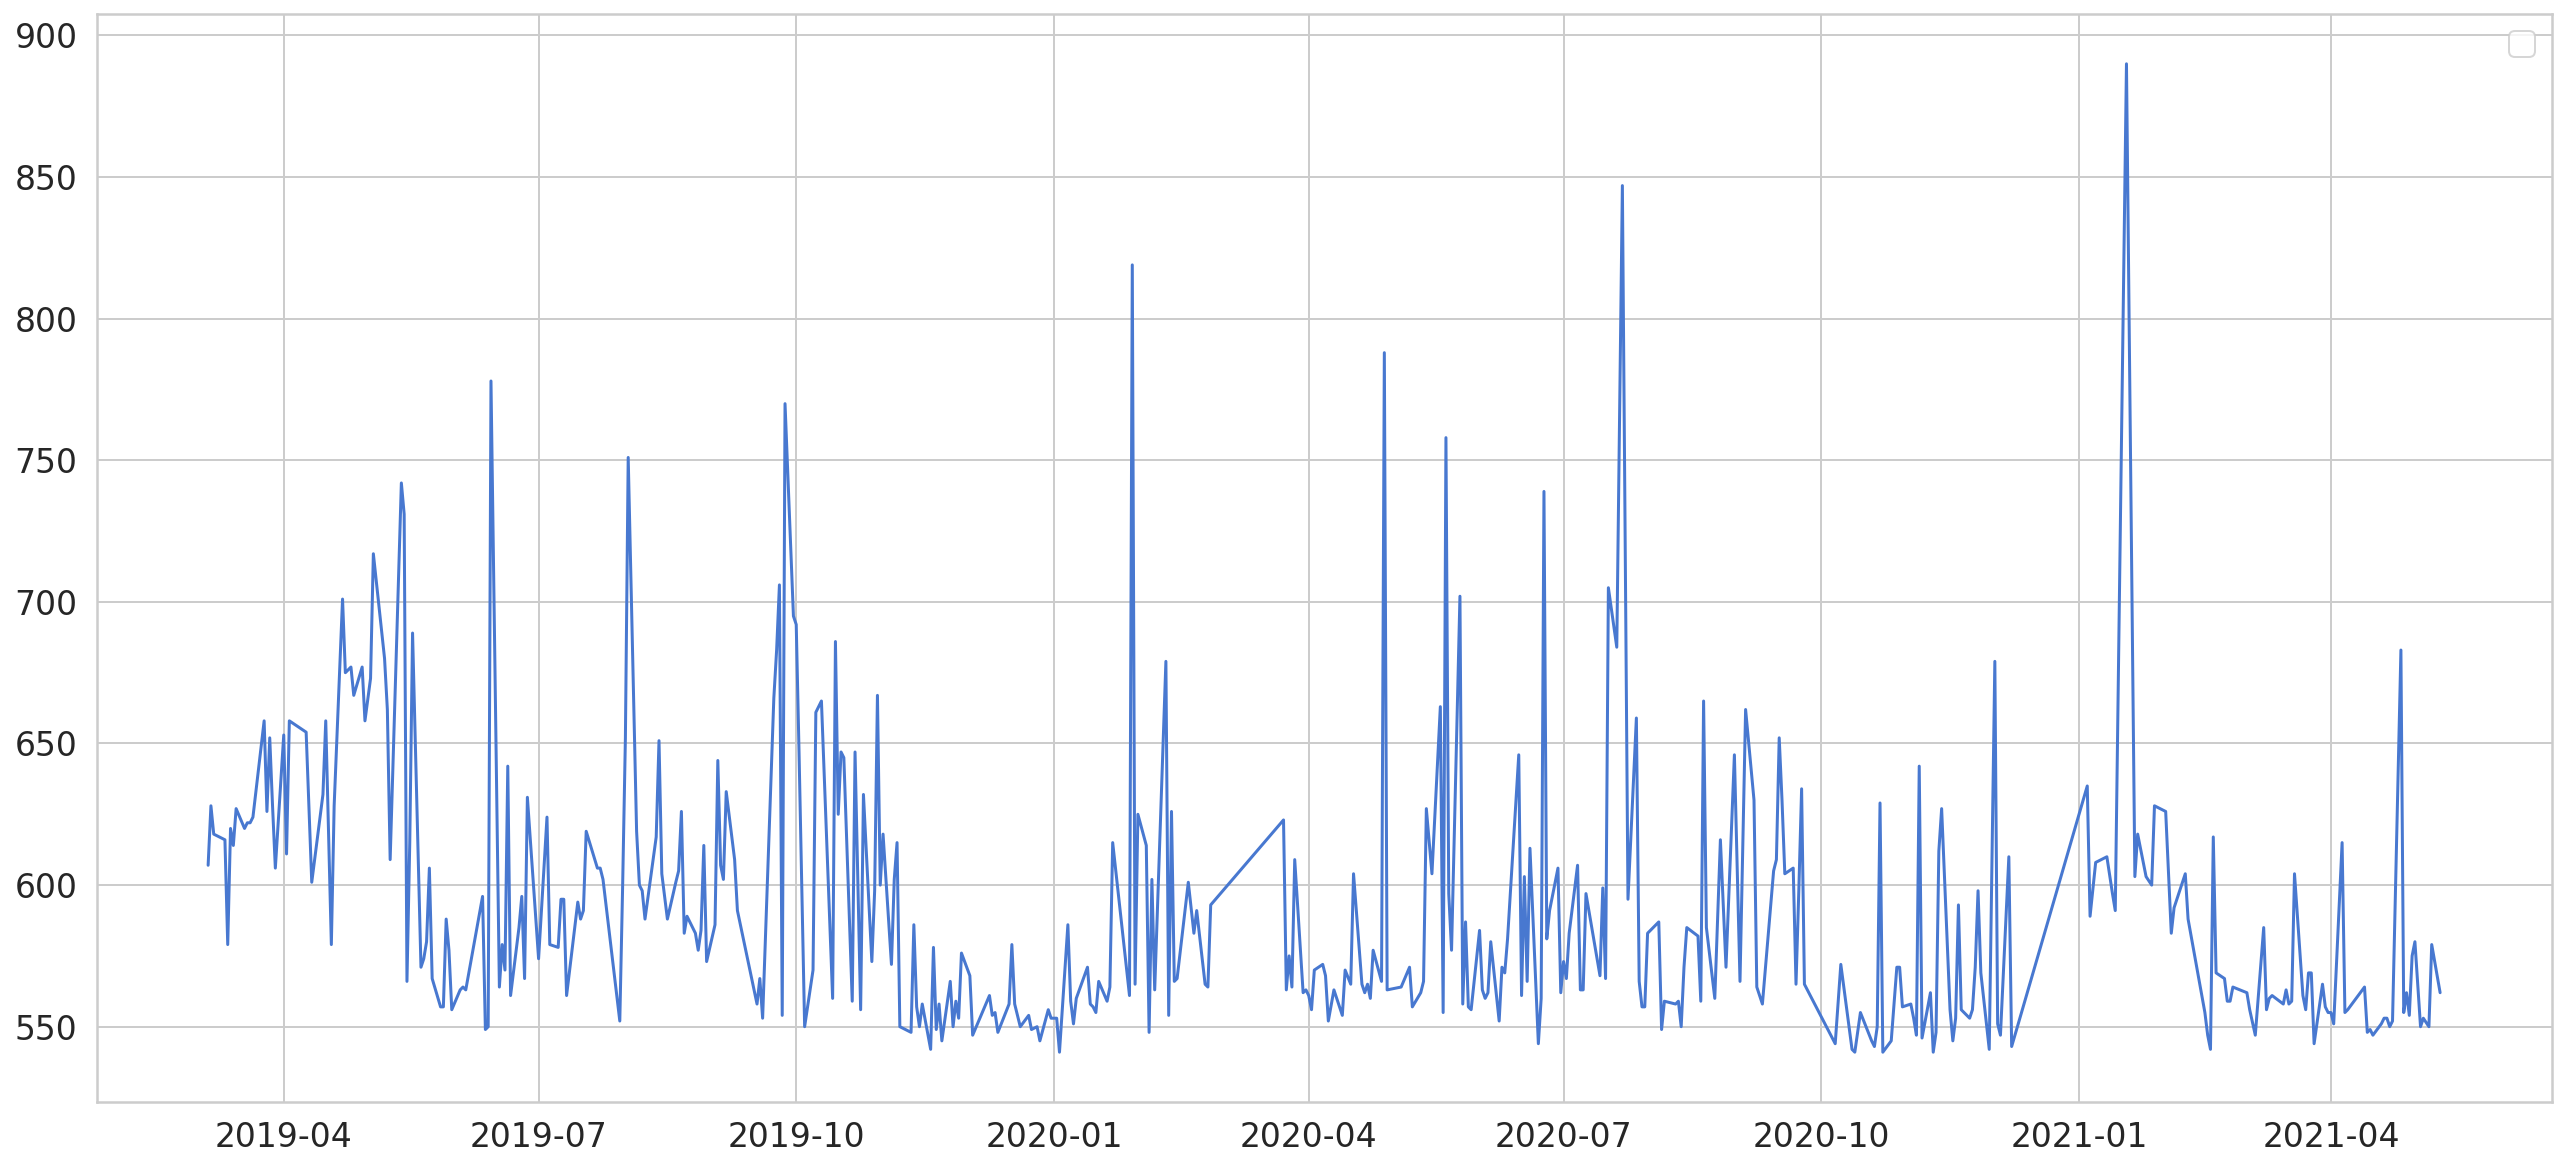

In [6]:
plt.plot(df['t'], label='')
plt.legend()

In [7]:
train_size = int(len(df) * 0.95)
test_size = len(df) - train_size
train, test = df.iloc[0:train_size], df.iloc[train_size:len(df)]
print(train.shape, test.shape)

(413, 4) (22, 4)


In [8]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler = scaler.fit(train[['t']])

train['t'] = scaler.transform(train[['t']])
test['t'] = scaler.transform(test[['t']])

/home/sjhyeon/venv/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/sjhyeon/venv/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


In [9]:
def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X.iloc[i:(i + time_steps)].values
        Xs.append(v)        
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)

In [11]:
TIME_STEPS = 5

# reshape to [samples, time_steps, n_features]

X_train, y_train = create_dataset(train[['t']], train.t, TIME_STEPS)
X_test, y_test = create_dataset(test[['t']], test.t, TIME_STEPS)

print(X_train.shape)

(408, 5, 1)


In [12]:
model = keras.Sequential()
model.add(keras.layers.LSTM(
    units=64, 
    input_shape=(X_train.shape[1], X_train.shape[2])
))
model.add(keras.layers.Dropout(rate=0.1))
model.add(keras.layers.RepeatVector(n=X_train.shape[1]))
model.add(keras.layers.LSTM(units=64, return_sequences=True))
model.add(keras.layers.Dropout(rate=0.1))
model.add(keras.layers.TimeDistributed(keras.layers.Dense(units=X_train.shape[2])))
model.compile(loss='mae', optimizer='adam')

In [13]:
history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=320,
    validation_split=0.1,
    shuffle=False
)

Epoch 1/100
2/2 [==============================] - 4s 938ms/step - loss: 0.6922 - val_loss: 1.0385
Epoch 2/100
2/2 [==============================] - 0s 100ms/step - loss: 0.6745 - val_loss: 1.0079
Epoch 3/100
2/2 [==============================] - 0s 91ms/step - loss: 0.6616 - val_loss: 0.9776
Epoch 4/100
2/2 [==============================] - 0s 70ms/step - loss: 0.6499 - val_loss: 0.9493
Epoch 5/100
2/2 [==============================] - 0s 91ms/step - loss: 0.6385 - val_loss: 0.9220
Epoch 6/100
2/2 [==============================] - 0s 81ms/step - loss: 0.6258 - val_loss: 0.8960
Epoch 7/100
2/2 [==============================] - 0s 89ms/step - loss: 0.6148 - val_loss: 0.8734
Epoch 8/100
2/2 [==============================] - 0s 69ms/step - loss: 0.6035 - val_loss: 0.8547
Epoch 9/100
2/2 [==============================] - 0s 90ms/step - loss: 0.5933 - val_loss: 0.8421
Epoch 10/100
2/2 [==============================] - 0s 86ms/step - loss: 0.5874 - val_loss: 0.8376
Epoch 11/100
2/2 

2/2 [==============================] - 0s 80ms/step - loss: 0.5454 - val_loss: 0.9962
Epoch 84/100
2/2 [==============================] - 0s 98ms/step - loss: 0.5468 - val_loss: 0.9992
Epoch 85/100
2/2 [==============================] - 0s 71ms/step - loss: 0.5465 - val_loss: 0.9996
Epoch 86/100
2/2 [==============================] - 0s 73ms/step - loss: 0.5467 - val_loss: 0.9973
Epoch 87/100
2/2 [==============================] - 0s 94ms/step - loss: 0.5480 - val_loss: 0.9959
Epoch 88/100
2/2 [==============================] - 0s 110ms/step - loss: 0.5457 - val_loss: 0.9976
Epoch 89/100
2/2 [==============================] - 0s 98ms/step - loss: 0.5453 - val_loss: 1.0013
Epoch 90/100
2/2 [==============================] - 0s 91ms/step - loss: 0.5474 - val_loss: 1.0066
Epoch 91/100
2/2 [==============================] - 0s 86ms/step - loss: 0.5472 - val_loss: 1.0118
Epoch 92/100
2/2 [==============================] - 0s 94ms/step - loss: 0.5464 - val_loss: 1.0118
Epoch 93/100
2/2 [====

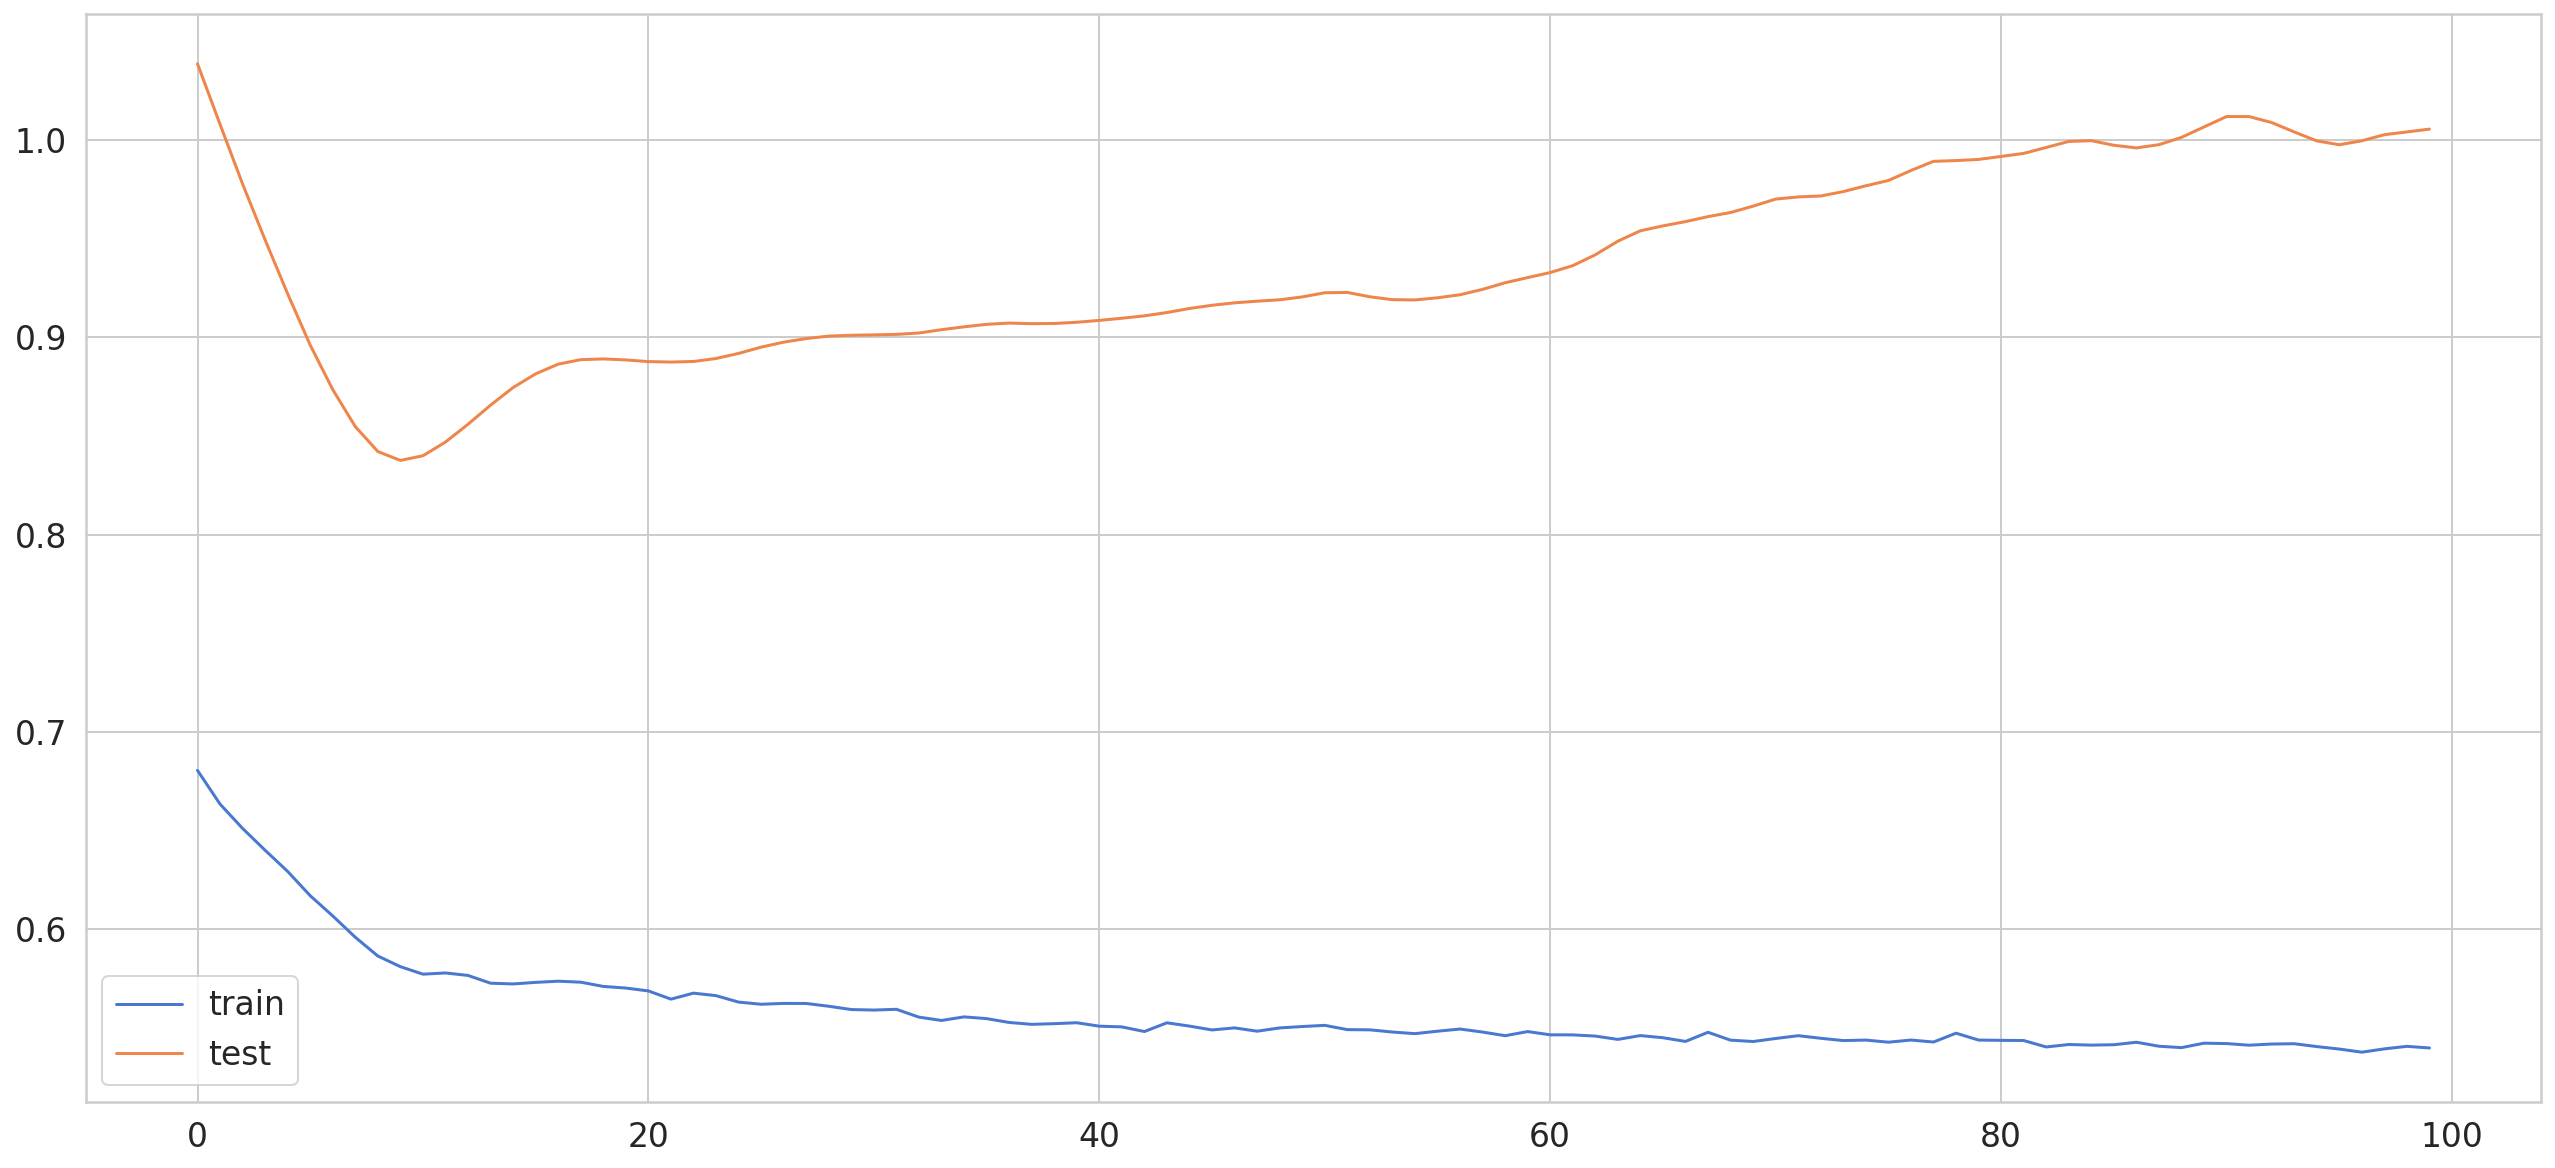

In [14]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend();

In [15]:
X_train_pred = model.predict(X_train)

train_mae_loss = np.mean(np.abs(X_train_pred - X_train), axis=1)

/home/sjhyeon/venv/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

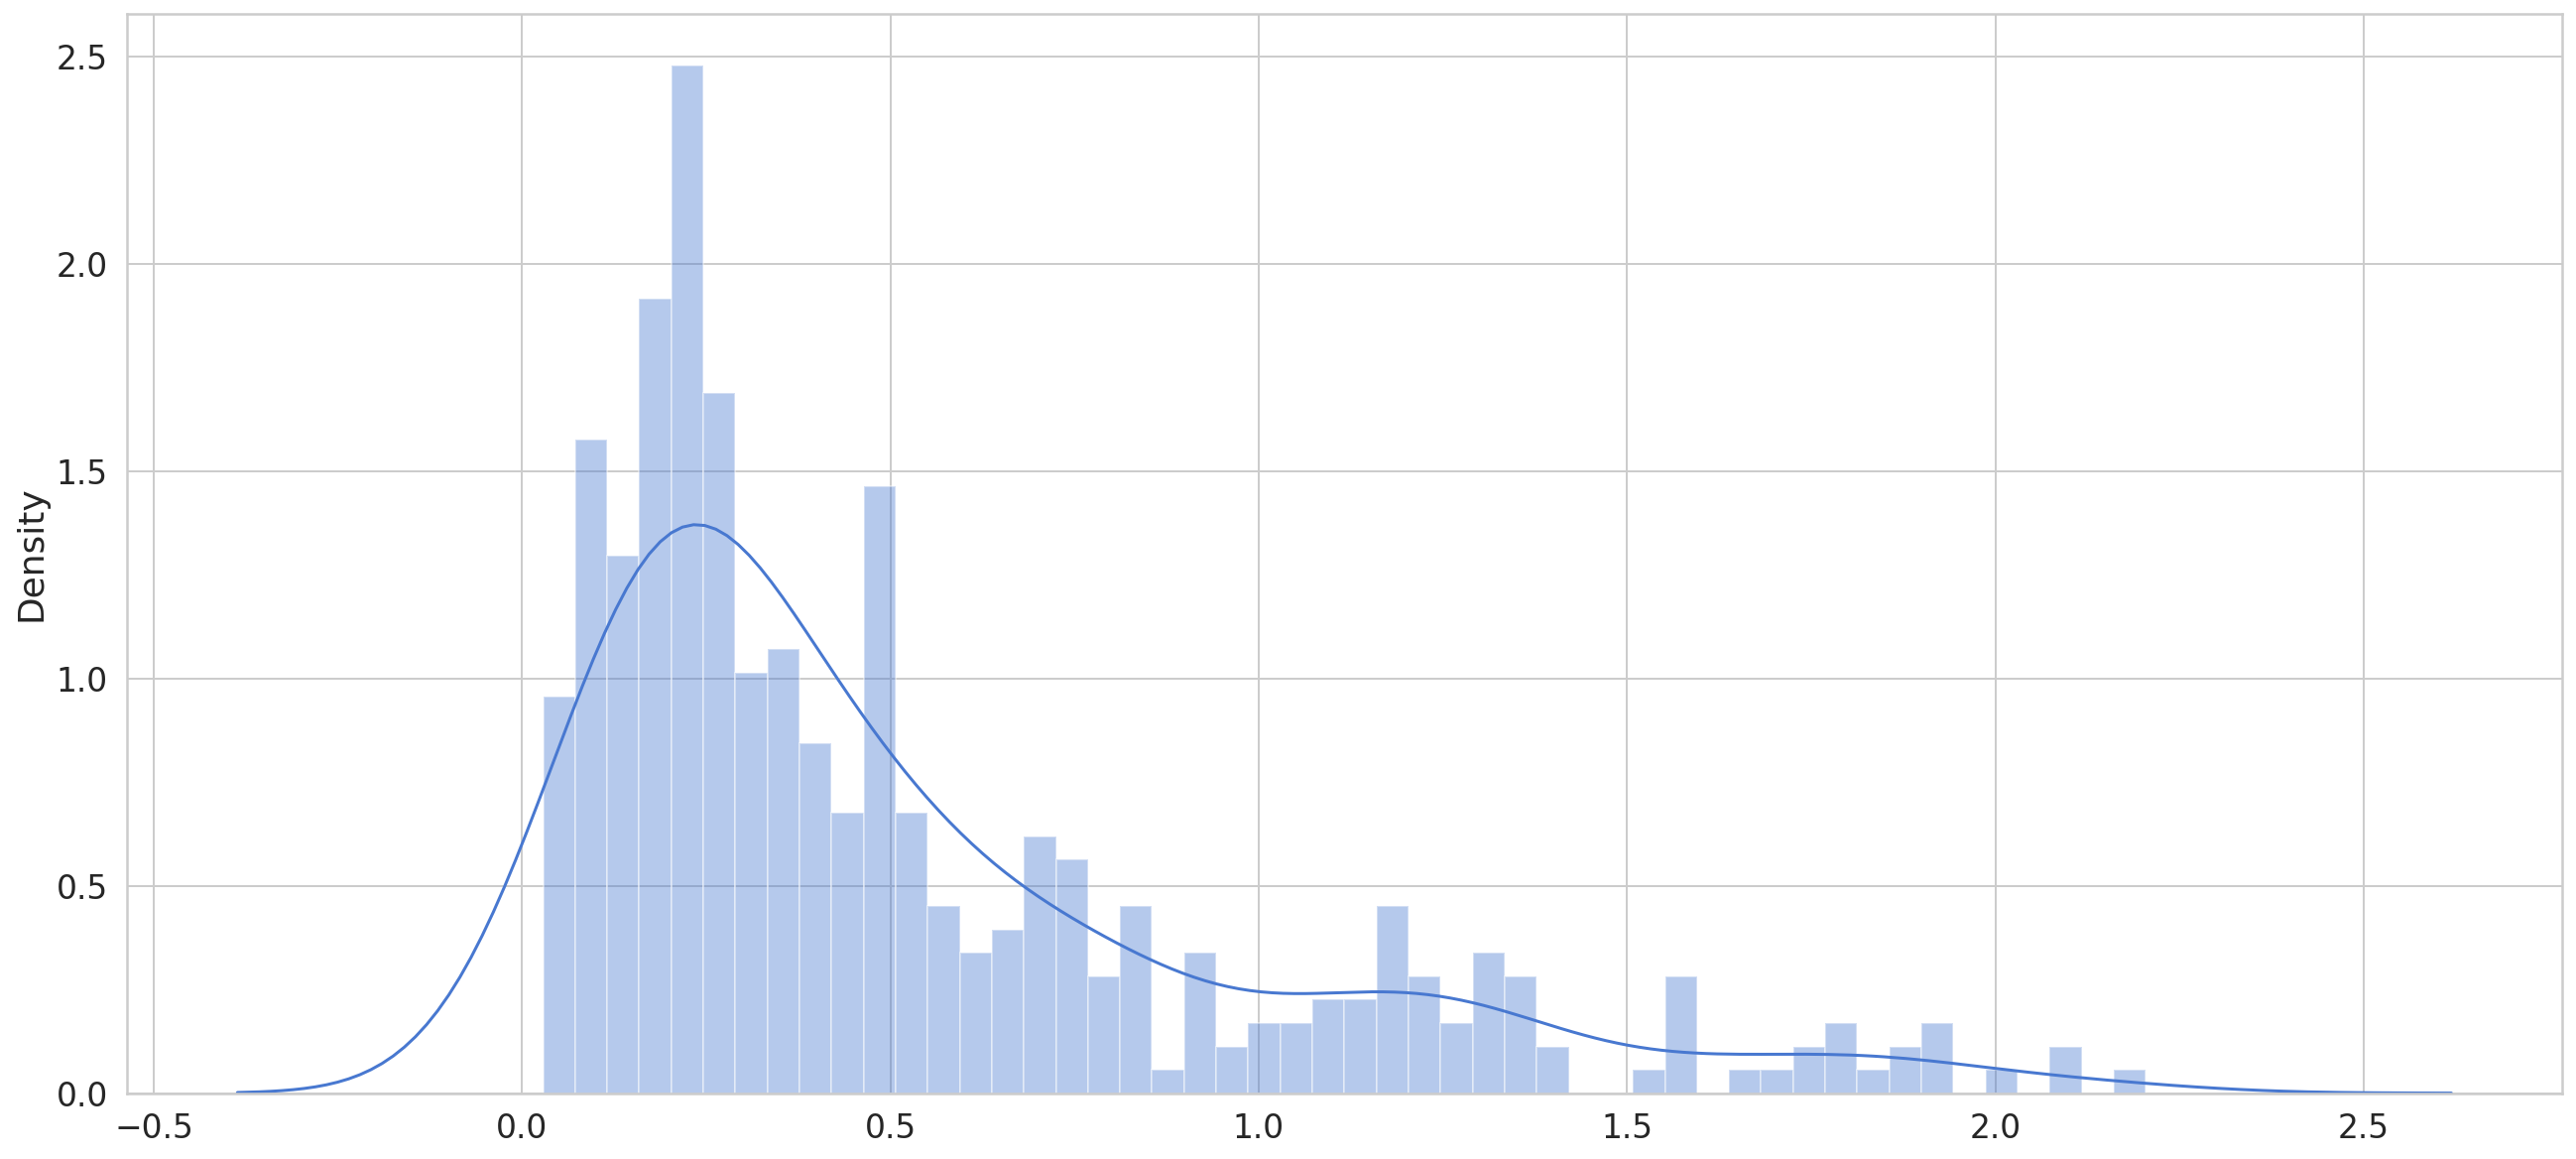

In [16]:
sns.distplot(train_mae_loss, bins=50, kde=True)

In [18]:
X_test_pred = model.predict(X_test)

test_mae_loss = np.mean(np.abs(X_test_pred - X_test), axis=1)

In [25]:
THRESHOLD = 0.7

test_score_df = pd.DataFrame(index=test[TIME_STEPS:].index)
test_score_df['loss'] = test_mae_loss
test_score_df['threshold'] = THRESHOLD
test_score_df['anomaly'] = test_score_df.loss > test_score_df.threshold
test_score_df['t'] = test[TIME_STEPS:].t

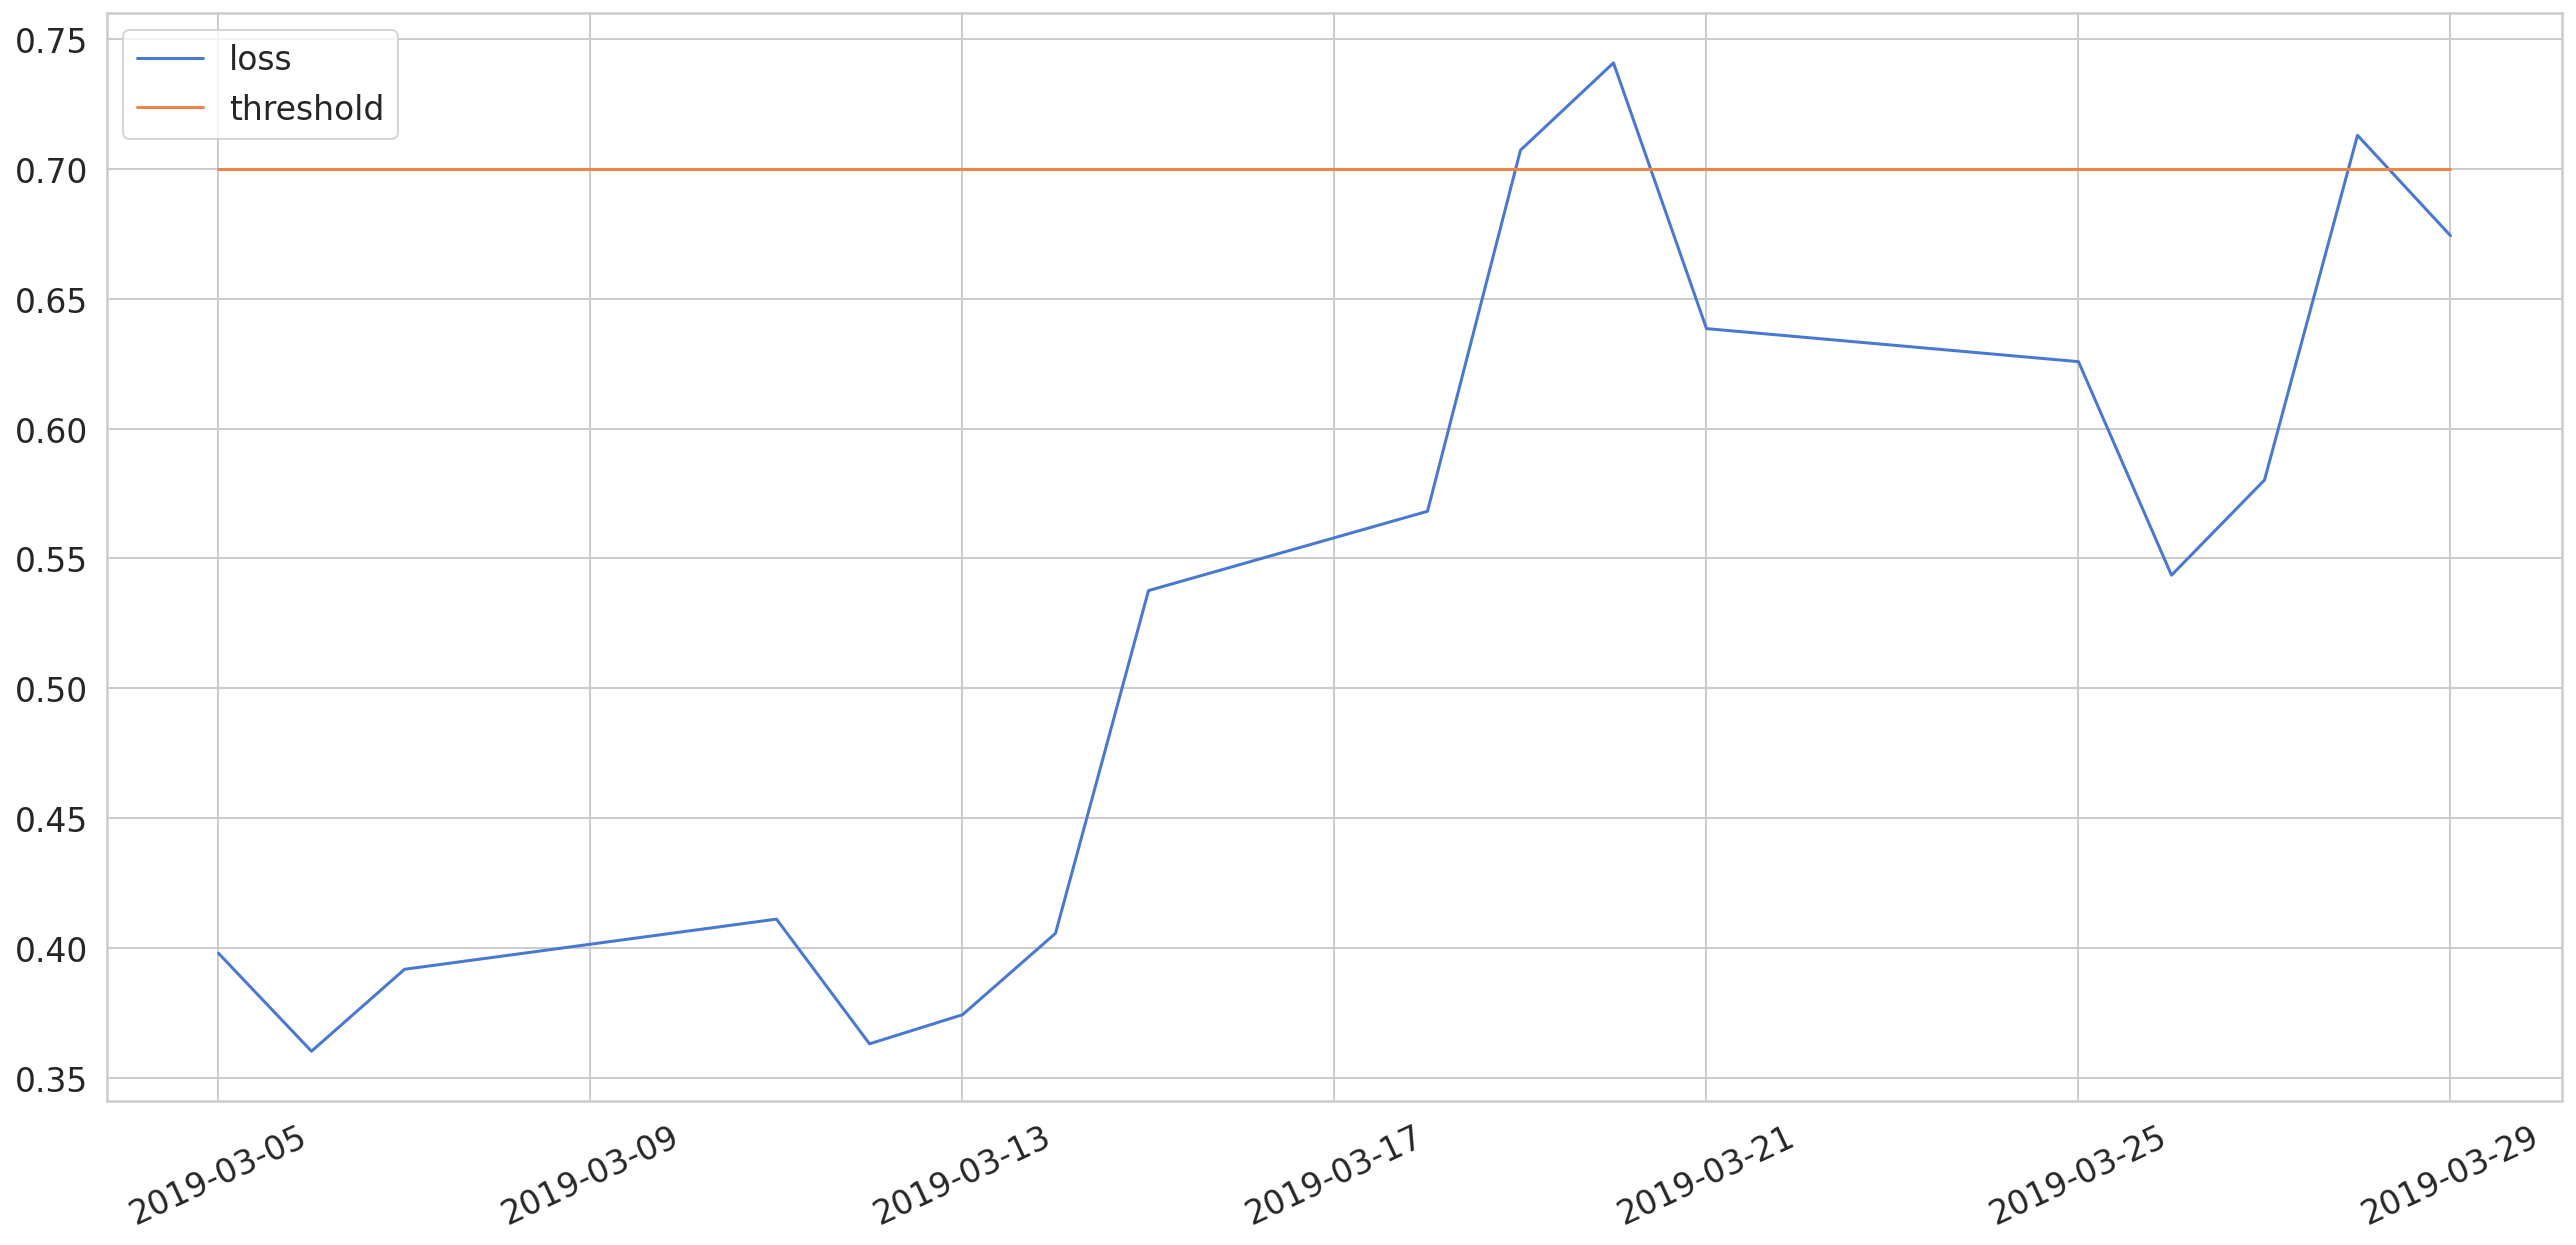

In [26]:
plt.plot(test_score_df.index, test_score_df.loss, label='loss')
plt.plot(test_score_df.index, test_score_df.threshold, label='threshold')
plt.xticks(rotation=25)
plt.legend();

In [27]:
anomalies = test_score_df[test_score_df.anomaly == True]
anomalies.head()

,loss,threshold,anomaly,t
date,,,,
2019-03-28,0.712893,0.7,True,0.763242
2019-03-20,0.740785,0.7,True,0.642737
2019-03-19,0.707181,0.7,True,0.642737


/home/sjhyeon/venv/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


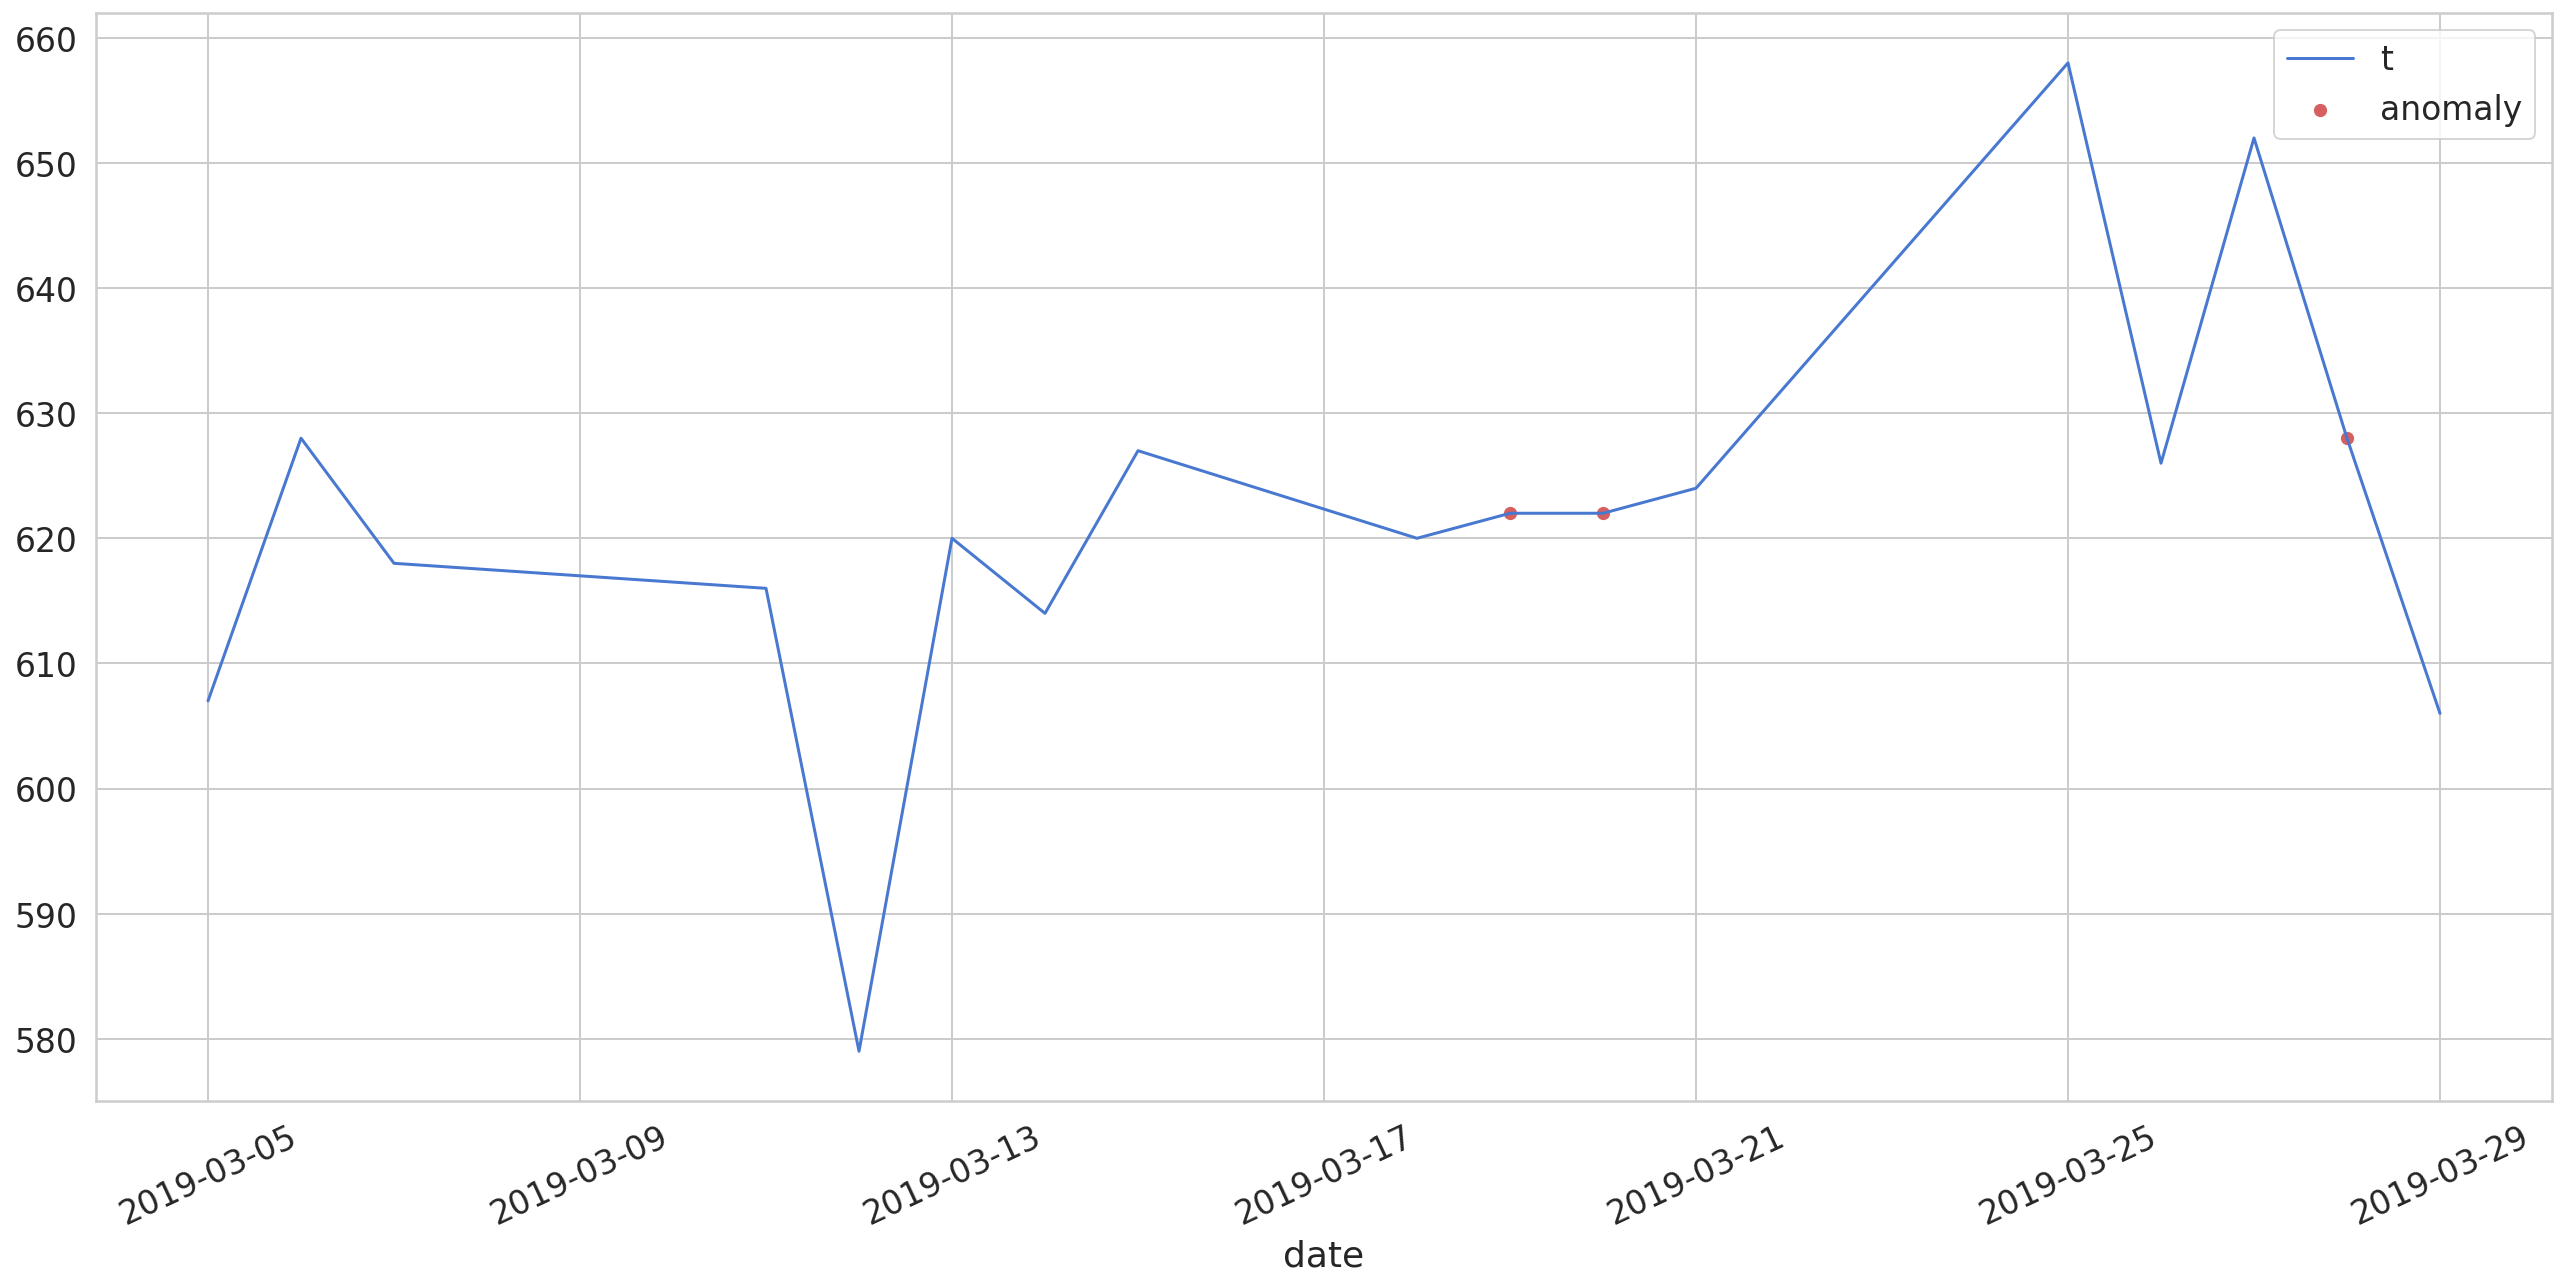

In [29]:
plt.plot(
  test[TIME_STEPS:].index, 
  scaler.inverse_transform(test[TIME_STEPS:].t), 
  label='t'
);

sns.scatterplot(
  anomalies.index,
  scaler.inverse_transform(anomalies.t),
  color=sns.color_palette()[3],
  s=52,
  label='anomaly'
)
plt.xticks(rotation=25)
plt.legend();